In [2]:
import numpy as np
import pandas as pd
import rpy2   # Allows Python code to call R functions
import rpy2.robjects   # Provides a high-level interface to access R objects and functions from Python
rpy2.robjects.r['options'](warn=-1)  # Set R global options to suppress warning messages during execution
from rpy2.robjects.packages import importr   # importr: Import R packages into the Python environment
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()  # Activate automatic conversion between numpy and R arrays
importr('RCIT')   # RCIT is an R package for performing conditional and unconditional independence tests
import statsmodels.api as sm
from scipy.stats import pearsonr
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from contextlib import contextmanager
import statsmodels.api as sm

In [3]:
regression_data = pd.read_csv('../merged_data_sss.csv')
dataset_raw = pd.read_csv('../dataset_raw.csv')
regression_data = regression_data.drop('Unnamed: 0', axis=1)
regression_data.describe()

,gvkey,fyear,month,RET,MOM,BETA,VOLAT,total_emission_scope1,total_emission_scope2,emission_growth_scope1,...,carbon_intensity_scope2,LOGSIZE,B/M,LEVERAGE,INVEST/A,ROE,LOGPPE,SALESGR,EPSGR,RET1
count,81605.000000,81605.000000,81605.000000,81605.000000,81605.000000,81605.000000,81605.000000,81605.000000,81605.000000,81605.000000,...,81605.000000,81605.000000,81605.000000,81605.000000,81605.000000,81605.000000,81605.000000,81605.000000,81605.000000,81605.000000
mean,61120.654923,2017.409767,6.522738,1.285111,0.120438,1.195033,0.103849,10.411239,10.627489,0.053134,...,0.314301,8.235747,0.577298,0.275880,0.035363,7.217507,6.841127,0.011243,0.004939,17.425595
std,69006.711553,2.158369,3.451686,12.473213,0.432692,0.727854,0.057046,2.689473,2.067171,0.296586,...,0.381090,1.762027,0.530395,0.215301,0.033117,33.035337,2.093872,0.328364,0.227102,53.736741
min,1004.000000,2011.000000,1.000000,-87.697842,-0.832704,-1.044560,0.025872,0.693147,2.544276,-0.587399,...,0.008185,-4.612195,-0.040954,0.000000,0.000000,-109.224422,-2.465104,-2.260408,-1.598919,-95.067633
25%,10860.000000,2016.000000,4.000000,-4.819277,-0.124580,0.757661,0.063082,8.641213,9.258057,-0.074867,...,0.085381,7.070696,0.230611,0.088988,0.012404,0.751054,5.498769,-0.015899,-0.022173,-9.791332
50%,24783.000000,2018.000000,7.000000,1.053142,0.082349,1.119520,0.090176,10.219274,10.620766,0.025733,...,0.176111,8.231717,0.444195,0.251456,0.025776,10.303030,6.880971,0.021430,0.003362,11.590107
75%,133869.000000,2019.000000,10.000000,6.870229,0.297905,1.546813,0.129241,11.925332,12.018952,0.137206,...,0.377914,9.407562,0.758144,0.412147,0.047656,19.134897,8.165563,0.073998,0.027182,34.970843
max,328795.000000,2020.000000,12.000000,99.191686,3.250000,4.147888,0.356740,18.713283,16.571679,1.124937,...,1.780249,14.627616,2.663034,0.814584,0.163615,91.432361,13.144907,1.647431,1.808117,1042.570281


In [4]:
dataset_raw['SALES'] = dataset_raw.groupby(['gvkey', 'fyear'])['sale'].transform(lambda x: np.log(x))
regression_data = regression_data.merge(dataset_raw[['gvkey', 'fyear', 'SALES']], on=['gvkey', 'fyear'], how='left')

In [5]:
regression_data = regression_data.sort_values(by=['gvkey', 'fyear', 'month'])

columns_to_shift = ['RET', 'MOM', 'BETA', 'VOLAT',
       'total_emission_scope1', 'total_emission_scope2',
       'emission_growth_scope1', 'emission_growth_scope2',
       'carbon_intensity_scope1', 'carbon_intensity_scope2', 'LOGSIZE', 'B/M',
       'LEVERAGE', 'INVEST/A', 'ROE', 'LOGPPE', 'SALESGR', 'EPSGR', 'RET1', 'SALES']

def shift_if_consecutive(group):
    group = group.sort_values(by='datatime')
    
    group['datatime'] = pd.to_datetime(group['datatime'])
    
    # check if data is consecutive on year-month
    group['consecutive'] = group['datatime'].diff().dt.days <= 31
    
    for col in columns_to_shift:
        group[f'{col}_t-1'] = group[col].shift(-1)
        group[f'{col}_t-1'] = group.apply(lambda row: row[col] if not row['consecutive'] else row[f'{col}_t-1'], axis=1)
        group[f'{col}_t+1'] = group[col].shift(+1)
        group[f'{col}_t+1'] = group.apply(lambda row: row[col] if not row['consecutive'] else row[f'{col}_t+1'], axis=1)
    
    return group.drop(columns=['consecutive', 'datatime'])

# apply to each gvkey group
regression_data_shifted = regression_data.groupby('gvkey').apply(shift_if_consecutive)
regression_data_shifted.columns = [col.replace('/', '_') for col in regression_data_shifted.columns]

print(regression_data_shifted.head())

         gvkey  fyear  month       RET       MOM      BETA     VOLAT  \
gvkey                                                                  
1004  0   1004   2017      1 -1.815431  0.433590  1.728236  0.106410   
      1   1004   2017      2  3.790447  0.695722  1.697156  0.106333   
      2   1004   2017      3 -0.148456  0.499601  1.585366  0.106969   
      3   1004   2017      4  7.017544  0.432948  1.536825  0.107289   
      4   1004   2017      5 -3.834398  0.448269  1.553771  0.109533   

         total_emission_scope1  total_emission_scope2  emission_growth_scope1  \
gvkey                                                                           
1004  0              10.991192              10.418976               -0.004909   
      1              10.991192              10.418976               -0.004909   
      2              10.991192              10.418976               -0.004909   
      3              10.991192              10.418976               -0.004909   
      4  

C:\Users\18906\AppData\Local\Temp\ipykernel_30856\3985392856.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  regression_data_shifted = regression_data.groupby('gvkey').apply(shift_if_consecutive)


In [6]:
regression_data_shifted = regression_data_shifted.replace([np.inf, -np.inf], np.nan)
regression_data_shifted = regression_data_shifted.dropna()
regression_data_shifted.describe()

,gvkey,fyear,month,RET,MOM,BETA,VOLAT,total_emission_scope1,total_emission_scope2,emission_growth_scope1,...,LOGPPE_t-1,LOGPPE_t+1,SALESGR_t-1,SALESGR_t+1,EPSGR_t-1,EPSGR_t+1,RET1_t-1,RET1_t+1,SALES_t-1,SALES_t+1
count,80417.000000,80417.000000,80417.000000,80417.000000,80417.000000,80417.000000,80417.000000,80417.000000,80417.000000,80417.000000,...,80417.000000,80417.000000,80417.000000,80417.000000,80417.000000,80417.000000,80417.000000,80417.000000,80417.000000,80417.000000
mean,60934.709129,2017.365768,6.427124,1.207831,0.118837,1.195408,0.102690,10.427427,10.644521,0.053041,...,6.860603,6.846327,0.009644,0.015504,0.004895,0.006359,17.351878,17.265085,7.757181,7.753443
std,68966.413175,2.153128,3.404401,12.443089,0.428752,0.728405,0.056120,2.688870,2.068068,0.296440,...,2.091782,2.096405,0.329561,0.323293,0.229140,0.227358,53.721223,52.755607,1.761583,1.762147
min,1004.000000,2011.000000,1.000000,-87.697842,-0.832704,-1.044560,0.025872,0.693147,2.544276,-0.587399,...,-2.465104,-2.465104,-2.260408,-2.260408,-1.598919,-1.598919,-95.067633,-95.067633,0.364643,0.364643
25%,10839.000000,2016.000000,3.000000,-4.869890,-0.124349,0.757927,0.062603,8.652251,9.275884,-0.075011,...,5.519551,5.500691,-0.016557,-0.013876,-0.022434,-0.021749,-9.863576,-9.723871,6.688498,6.682860
50%,24678.000000,2018.000000,6.000000,1.002616,0.082460,1.119641,0.089248,10.238035,10.633140,0.025733,...,6.898329,6.887144,0.021215,0.022174,0.003280,0.003659,11.574776,11.786095,7.787797,7.786098
75%,133868.000000,2019.000000,9.000000,6.798757,0.296582,1.547152,0.127794,11.960108,12.041587,0.137181,...,8.197257,8.177516,0.073486,0.075707,0.027177,0.027513,34.918820,34.946365,8.910653,8.906529
max,328795.000000,2020.000000,12.000000,99.191686,3.250000,4.147888,0.356740,18.713283,16.571679,1.124937,...,13.144907,13.144907,1.647431,1.647431,1.808117,1.808117,1042.570281,1042.570281,13.230200,13.230200


In [10]:
regression_data_shifted.drop(columns=['GICS Sector Name'], inplace=True)

### RCIT functions

In [11]:
def RCIT(X, x_, y_, z_=None, random_seed=False):
    if random_seed: seed = np.random.choice(1000)
    else: seed = np.random.choice(1000) 
    local_copy = X.copy()
    array = np.array(local_copy.transpose().dropna())
    dim, T = array.shape
    x_vals = array[x_]
    y_vals = array[y_]
    if z_ != None:
        z_vals = array[z_].T.copy()
        rcot = rpy2.robjects.r['RCIT'](x_vals, y_vals, z_vals, seed = seed)
    else:
        rcot = rpy2.robjects.r['RCIT'](x_vals, y_vals, seed = seed)
    return float(rcot.rx2('p')[0])

In [12]:
def RCIT_values(X, x_, y_, z_=None, random_seed=False, n_runs=10):
    
    p_values = []  
    
    for _ in range(n_runs):
        p_value = RCIT(X, x_, y_, z_, random_seed)
        p_values.append(p_value)
    
    return p_values

In [16]:
def cross_sectional_rcit(data, x, y, z, num_subsets):
    subset_size = len(data) // num_subsets
    p_values = []

    for i in range(num_subsets):
        subset = data.iloc[i * subset_size:(i + 1) * subset_size]
        p_value = RCIT(subset, x, y, z)
        p_values.append(p_value)

    return p_values

In [13]:
def chi2_test(p_values, num_bins=10):
    """
    Perform a chi-squared test for uniformity on the given p-values.

    Parameters:
    p_values (list or array): List of p-values to be tested.
    num_bins (int): Number of bins for the histogram. 

    Returns:
    chi2_stat (float): Chi-squared statistic.
    p_val (float): p-value of the uniformity test.
    """
    # Create bins for the histogram
    bins = np.linspace(0, 1, num_bins)
    
    # Calculate observed frequencies
    observed, _ = np.histogram(p_values, bins=bins)
    
    # Calculate expected frequencies
    total_observations = sum(observed)
    num_groups = len(observed)
    expected = [total_observations / num_groups] * num_groups
    
    # Perform chi-squared test
    chi2_stat, p_val = chisquare(observed, expected)
    
    return chi2_stat, p_val

# Example usage
p_values2 = np.random.uniform(0, 2, 1000)  # Example p-values
chi2_stat, p_val = chi2_test(p_values2)

print(f"chi2_stat: {chi2_stat}")
print(f"uniformity p value: {p_val}")

chi2_stat: 4.9125000000000005
uniformity p value: 0.7668860335811113


In [14]:
def graph(p_values):

    # Plotting the histogram of p-values
    plt.figure(figsize=(5,3))
    plt.hist(p_values, bins=50, color='blue', alpha=0.6, label='RCIT p-values')
    plt.xlabel('p-value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [15]:
def graph2(p_values1, p_values2):
    # Plotting the histogram of p-values
    plt.figure(figsize=(5,3))
    plt.hist(p_values1, bins=50, color='blue', alpha=0.6, label='Conditional test')
    plt.hist(p_values2, bins=50, color='red', alpha=0.6, label='Unconditional test')
    plt.xlabel('p-value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

#### Simulated examples

##### 1. Collider bias

In [103]:
# Set seed for reproducibility
np.random.seed(2024)

# Number of samples
n_samples = 800

# Generate data according to the model
X = np.random.normal(0, 1, n_samples)
H = np.random.normal(0, 1, n_samples)
Y = 1.5 * X + np.random.normal(0, 1, n_samples)
Z = - Y - 0.75 * H + np.random.normal(0, 1, n_samples)

# Save the generated data to variables
data = {
    'X': X,
    'Z': Z,
    'H': H,
    'Y': Y
}

In [104]:
# Extract data
X = data['X']
Y = data['Y']
Z = data['Z']
H = data['H']

# First regression: H on X
X_with_const = sm.add_constant(pd.DataFrame({'X': X}))
model1 = sm.OLS(H, X_with_const).fit()

# Second regression: H on X and Y
XY_with_const = sm.add_constant(pd.DataFrame({'X': X, 'Z': Z}))
model2 = sm.OLS(H, XY_with_const).fit()

# Display summaries
model1_summary = model1.summary()
model2_summary = model2.summary()

print(model1_summary)
print(model2_summary)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                  0.006932
Date:                  周五, 21 6月 2024   Prob (F-statistic):              0.934
Time:                        07:57:59   Log-Likelihood:                -1133.6
No. Observations:                 800   AIC:                             2271.
Df Residuals:                     798   BIC:                             2281.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0128      0.035     -0.361      0.7

##### 2. Mediator Bias

In [125]:
# Set seed for reproducibility
np.random.seed(20)

# Number of samples
n_samples = 800

# Generate data according to the model
X = np.random.normal(0, 1, n_samples)
Y = 0.5 * X + np.random.normal(0, 1, n_samples)
Z = Y + np.random.normal(0, 1, n_samples)
H = 0.75 * Z + np.random.normal(0, 1, n_samples)

# Save the generated data to variables
data = {
    'X': X,
    'Z': Z,
    'H': H,
    'Y': Y
}

In [126]:
# Extract data
X = data['X']
Y = data['Y']
Z = data['Z']
H = data['H']

# First regression: H on X
X_with_const = sm.add_constant(pd.DataFrame({'X': X}))
model1 = sm.OLS(H, X_with_const).fit()

# Second regression: H on X and Y
XY_with_const = sm.add_constant(pd.DataFrame({'X': X, 'Y': Y}))
model2 = sm.OLS(H, XY_with_const).fit()

# Second regression: H on X and Y
XZ_with_const = sm.add_constant(pd.DataFrame({'X': X, 'Z': Z}))
model3 = sm.OLS(H, XZ_with_const).fit()

# Display summaries
model1_summary = model1.summary()
model2_summary = model2.summary()
model3_summary = model3.summary()

print(model1_summary)
print(model2_summary)
print(model3_summary)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     70.92
Date:                  周五, 21 6月 2024   Prob (F-statistic):           1.72e-16
Time:                        16:00:33   Log-Likelihood:                -1417.9
No. Observations:                 800   AIC:                             2840.
Df Residuals:                     798   BIC:                             2849.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0071      0.050      0.141      0.8

##### 3. CIT example

In [13]:
p1=[]
p2=[]

for i in range(500):

    n_samples = 1000

    # data for X -> Y -> Z
    X_chain = np.random.normal(size=n_samples)
    Y_chain = 2*X_chain + np.random.normal(size=n_samples)
    Z_chain = np.cos(Y_chain) + np.random.normal(size=n_samples)

    chain_df = pd.DataFrame({'X_chain': X_chain, 'Y_chain': Y_chain, 'Z_chain': Z_chain})

    X1 = chain_df  
    x1 = chain_df.columns.get_loc('X_chain')
    y1 = chain_df.columns.get_loc('Z_chain')
    z1 = chain_df.columns.get_loc('Y_chain')

    p1.append(RCIT(X1, x1, y1, z1))
    p2.append(RCIT(X1, x1, y1, z_=None))

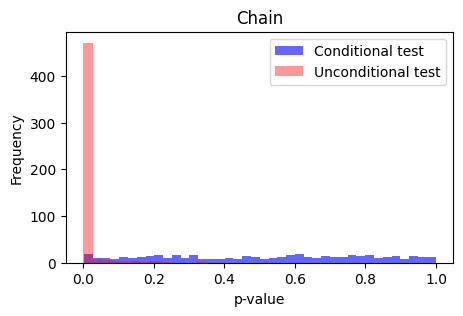

In [17]:
plt.figure(figsize=(5,3))
plt.hist(p1, bins=40, color='blue', alpha=0.6, label='Conditional test')
plt.hist(p2, bins=13, color='red', alpha=0.4, label='Unconditional test')
plt.xlabel('p-value')
plt.title('Chain')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [15]:
p11=[]
p22=[]

for i in range(500):

    n_samples = 1000

    # data for X -> Y -> Z
    X_collider = np.random.normal(size=n_samples)
    Z_collider = np.random.normal(size=n_samples)
    Y_collider = np.sin(X_collider) + 0.5 * Z_collider + np.random.normal(size=n_samples)

    collider_df = pd.DataFrame({'X_collider': X_collider, 'Y_collider': Y_collider, 'Z_collider': Z_collider})

    X11 = collider_df  
    x11 = collider_df.columns.get_loc('X_collider')
    y11 = collider_df.columns.get_loc('Z_collider')
    z11 = collider_df.columns.get_loc('Y_collider')

    p11.append(RCIT(X11, x11, y11, z11))
    p22.append(RCIT(X11, x11, y11, z_=None))

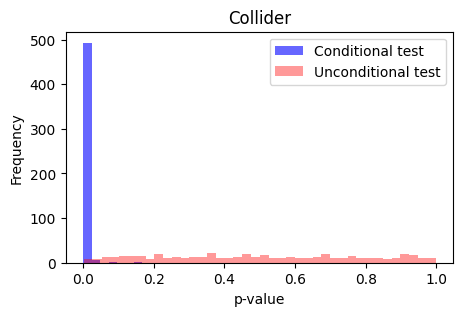

In [18]:
plt.figure(figsize=(5,3))
plt.hist(p11, bins=7, color='blue', alpha=0.6, label='Conditional test')
plt.hist(p22, bins=40, color='red', alpha=0.4, label='Unconditional test')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.title('Collider')
plt.legend()
plt.show()

### Conditional Independence Tests
#### 1.1. Determinants for Emissions

Emissions ⊥ LOGSIZE_t0 | INVEST/A, LEVERAGE, LOGPPE_t0, SALES

In [123]:
X = regression_data_shifted  

x = regression_data_shifted.columns.get_loc('total_emission_scope1')
y = regression_data_shifted.columns.get_loc('LOGSIZE_t-1')
z = [regression_data_shifted.columns.get_loc('SALES'), regression_data_shifted.columns.get_loc('LEVERAGE'),\
     regression_data_shifted.columns.get_loc('INVEST_A'), regression_data_shifted.columns.get_loc('LOGPPE_t-1')]

In [124]:
# run conditional independence tests
p_values1 = cross_sectional_rcit(X, x, y, z, num_subsets=222)
p_mean = np.average(p_values1)
print(f"average p value (conditional): {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values1, 200)
print(f"uniformity test p-value (conditional): {p_value}")

# run unconditional independence tests
p_values2 = cross_sectional_rcit(X, x, y, z=None, num_subsets=111)
p_mean = np.average(p_values2)
print(f"average p value (unconditional): {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values2, 100)
print(f"uniformity test p-value (unconditional): {p_value}")

average p value (conditional): 0.00045215288276580137
uniformity test p-value (conditional): 0.0
average p value (unconditional): 0.25121822501758023
uniformity test p-value (unconditional): 5.068513923673313e-32


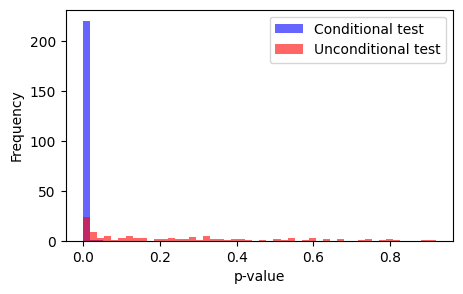

In [128]:
plt.figure(figsize=(5,3))
plt.hist(p_values1, bins=3, color='blue', alpha=0.6, label='Conditional test')
plt.hist(p_values2, bins=50, color='red', alpha=0.6, label='Unconditional test')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Emissions ⊥ LEVERAGE | INVEST/A, LOGPPE_t0, LOGSIZE_t0

In [116]:
X = regression_data_shifted  

x = regression_data_shifted.columns.get_loc('total_emission_scope2')
y = regression_data_shifted.columns.get_loc('LEVERAGE')
z = [regression_data_shifted.columns.get_loc('LOGPPE_t-1'), \
     regression_data_shifted.columns.get_loc('INVEST_A'), regression_data_shifted.columns.get_loc('LOGSIZE_t-1')]

In [117]:
# run RCIT cross-sectionally
p_values1 = cross_sectional_rcit(X, x, y, z, num_subsets=222)
p_mean = np.average(p_values1)
print(f"average p value: {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values1, 200)
print(f"Chi-square Statistic: {chi2_statistic}, P-value: {p_value}")

average p value: 0.01173221745676232
Chi-square Statistic: 40836.54054054053, P-value: 0.0


In [118]:
# run RCIT cross-sectionally
p_values2 = cross_sectional_rcit(X, x, y, z=None, num_subsets=111)
p_mean = np.average(p_values2)
print(f"average p value: {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values2, 100)
print(f"Chi-square Statistic: {chi2_statistic}, P-value: {p_value}")

average p value: 0.0013546191359298152
Chi-square Statistic: 10103.837837837838, P-value: 0.0


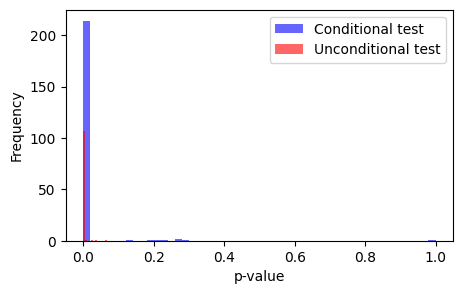

In [119]:
plt.figure(figsize=(5,3))
plt.hist(p_values1, bins=50, color='blue', alpha=0.6, label='Conditional test')
plt.hist(p_values2, bins=12, color='red', alpha=0.6, label='Unconditional test')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Emissions ⊥ SALES | INVEST/A, LOGSIZE_t0

In [145]:
X = regression_data_shifted  

x = regression_data_shifted.columns.get_loc('total_emission_scope2')
y = regression_data_shifted.columns.get_loc('SALES')
z = [regression_data_shifted.columns.get_loc('INVEST_A'), regression_data_shifted.columns.get_loc('LOGSIZE_t-1')]

In [146]:
# run conditional independence tests
p_values1 = cross_sectional_rcit(X, x, y, z, num_subsets=222)
p_mean = np.average(p_values1)
print(f"average p value (conditional): {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values1, 200)
print(f"uniformity test p-value (conditional): {p_value}")

# run unconditional independence tests
p_values2 = cross_sectional_rcit(X, x, y, z=None, num_subsets=111)
p_mean = np.average(p_values2)
print(f"average p value (unconditional): {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values2, 100)
print(f"uniformity test p-value (unconditional): {p_value}")

average p value (conditional): 0.008513358216580676
uniformity test p-value (conditional): 0.0
average p value (unconditional): 0.0017372686694234311
uniformity test p-value (unconditional): 0.0


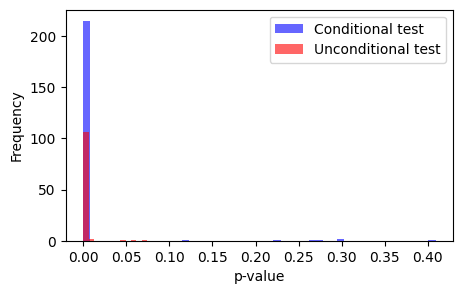

In [147]:
plt.figure(figsize=(5,3))
plt.hist(p_values1, bins=50, color='blue', alpha=0.6, label='Conditional test')
plt.hist(p_values2, bins=12, color='red', alpha=0.6, label='Unconditional test')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

INVEST/A ⊥ Emissions | LEVERAGE, LOGPPE_t0, LOGSIZE_t0, SALES

In [148]:
X = regression_data_shifted  

x = regression_data_shifted.columns.get_loc('total_emission_scope2')
y = regression_data_shifted.columns.get_loc('INVEST_A')
z = [regression_data_shifted.columns.get_loc('LOGPPE_t-1'), regression_data_shifted.columns.get_loc('LEVERAGE'),\
     regression_data_shifted.columns.get_loc('SALES'), regression_data_shifted.columns.get_loc('LOGSIZE_t-1')]

In [149]:
# run conditional independence tests
p_values1 = cross_sectional_rcit(X, x, y, z, num_subsets=222)
p_mean = np.average(p_values1)
print(f"average p value (conditional): {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values1, 200)
print(f"uniformity test p-value (conditional): {p_value}")

# run unconditional independence tests
p_values2 = cross_sectional_rcit(X, x, y, z=None, num_subsets=111)
p_mean = np.average(p_values2)
print(f"average p value (unconditional): {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values2, 100)
print(f"uniformity test p-value (unconditional): {p_value}")

average p value (conditional): 0.0045045045045045045
uniformity test p-value (conditional): 0.0
average p value (unconditional): 0.004879438765634091
uniformity test p-value (unconditional): 0.0


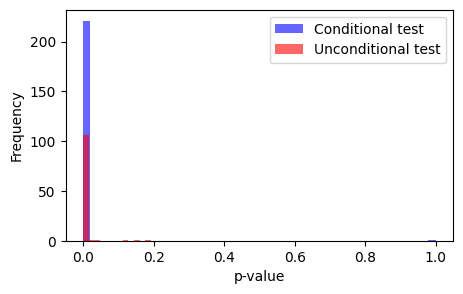

In [150]:
plt.figure(figsize=(5,3))
plt.hist(p_values1, bins=50, color='blue', alpha=0.6, label='Conditional test')
plt.hist(p_values2, bins=12, color='red', alpha=0.6, label='Unconditional test')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Emissions ⊥ LOGPPE_t0 | INVEST/A, LEVERAGE, LOGSIZE_t0

In [159]:
X = regression_data_shifted  

x = regression_data_shifted.columns.get_loc('total_emission_scope1')
y = regression_data_shifted.columns.get_loc('LOGPPE_t-1')
z = [regression_data_shifted.columns.get_loc('INVEST_A'), regression_data_shifted.columns.get_loc('LEVERAGE'),\
     regression_data_shifted.columns.get_loc('LOGSIZE_t-1')]

In [160]:
# run conditional independence tests
p_values1 = cross_sectional_rcit(X, x, y, z, num_subsets=222)
p_mean = np.average(p_values1)
print(f"average p value (conditional): {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values1, 200)
print(f"uniformity test p-value (conditional): {p_value}")

# run unconditional independence tests
p_values2 = cross_sectional_rcit(X, x, y, z=None, num_subsets=111)
p_mean = np.average(p_values2)
print(f"average p value (unconditional): {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values2, 100)
print(f"uniformity test p-value (unconditional): {p_value}")

average p value (conditional): 0.0003956691706838688
uniformity test p-value (conditional): 0.0
average p value (unconditional): 0.00010911149150422279
uniformity test p-value (unconditional): 0.0


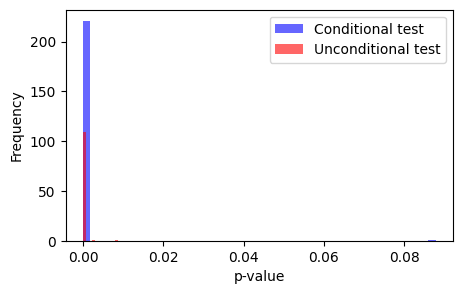

In [161]:
plt.figure(figsize=(5,3))
plt.hist(p_values1, bins=50, color='blue', alpha=0.6, label='Conditional test')
plt.hist(p_values2, bins=12, color='red', alpha=0.6, label='Unconditional test')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

B/M_t0 ⊥ Emissions | INVEST/A, LEVERAGE, LOGPPE_t0, LOGSIZE_t0

In [130]:
X = regression_data_shifted  

x = regression_data_shifted.columns.get_loc('total_emission_scope2')
y = regression_data_shifted.columns.get_loc('B_M_t-1')
z = [regression_data_shifted.columns.get_loc('LOGPPE_t-1'), regression_data_shifted.columns.get_loc('LEVERAGE'),\
     regression_data_shifted.columns.get_loc('INVEST_A'), regression_data_shifted.columns.get_loc('LOGSIZE_t-1')]

In [144]:
# run RCIT cross-sectionally
p_values1 = cross_sectional_rcit(X, x, y, z, num_subsets=222)
p_mean = np.average(p_values1)
print(f"average p value: {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values1, 200)
print(f"Chi-square Statistic: {chi2_statistic}, P-value: {p_value}")

average p value: 0.4910050959989726
Chi-square Statistic: 215.44144144144147, P-value: 0.18801179767796306


In [134]:
# run RCIT cross-sectionally
p_values2 = cross_sectional_rcit(X, x, y, z=None, num_subsets=111)
p_mean = np.average(p_values2)
print(f"average p value: {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values2, 100)
print(f"Chi-square Statistic: {chi2_statistic}, P-value: {p_value}")

average p value: 0.1306715361351756
Chi-square Statistic: 753.2432432432432, P-value: 1.1062889685239198e-101


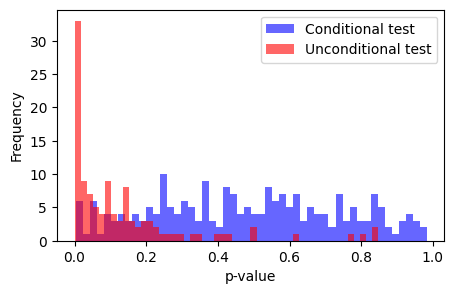

In [136]:
plt.figure(figsize=(5,3))
plt.hist(p_values1, bins=50, color='blue', alpha=0.6, label='Conditional test')
plt.hist(p_values2, bins=50, color='red', alpha=0.6, label='Unconditional test')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Emissions ⊥ VOLAT | LEVERAGE

In [175]:
X = regression_data_shifted  

x = regression_data_shifted.columns.get_loc('total_emission_scope1')
y = regression_data_shifted.columns.get_loc('VOLAT')
z = [regression_data_shifted.columns.get_loc('LEVERAGE')]

In [193]:
# normal
X = regression_data_shifted  

x = regression_data_shifted.columns.get_loc('RET1_t+1')
y = regression_data_shifted.columns.get_loc('total_emission_scope1_t+1')####
z = [regression_data_shifted.columns.get_loc('LOGPPE_t-1'), \
     regression_data_shifted.columns.get_loc('INVEST_A'), regression_data_shifted.columns.get_loc('LOGSIZE_t-1'),\
     regression_data_shifted.columns.get_loc('ROE'), regression_data_shifted.columns.get_loc('SALES')]

In [214]:
# normal
X = regression_data_shifted  

x = regression_data_shifted.columns.get_loc('MOM_t+1')
y = regression_data_shifted.columns.get_loc('RET_t+1')
z = [regression_data_shifted.columns.get_loc('LOGPPE_t-1'), regression_data_shifted.columns.get_loc('total_emission_scope1'), \
     regression_data_shifted.columns.get_loc('LOGSIZE_t-1'), regression_data_shifted.columns.get_loc('ROE'), \
     regression_data_shifted.columns.get_loc('INVEST_A')]

In [215]:
# run RCIT cross-sectionally
p_values2 = cross_sectional_rcit(X, x, y, z=None, num_subsets=100)
p_mean = np.average(p_values2)
print(f"average p value: {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values2, 10)
print(f"Chi-square Statistic: {chi2_statistic}, P-value: {p_value}")

average p value: 0.47644584824430114
Chi-square Statistic: 210.06306306306305, P-value: 0.26511876241941407


In [220]:
# run RCIT cross-sectionally
p_values1 = cross_sectional_rcit(X, x, y, z, num_subsets=222)
p_mean = np.average(p_values1)
print(f"average p value: {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values1, 200)
print(f"Chi-square Statistic: {chi2_statistic}, P-value: {p_value}")

average p value: 0.4388960690276134
Chi-square Statistic: 222.61261261261262, P-value: 0.11081982959319783


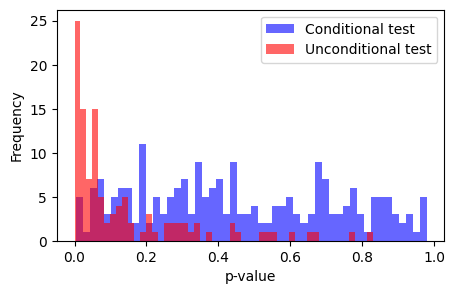

In [223]:
plt.figure(figsize=(5,3))
plt.hist(p_values1, bins=50, color='blue', alpha=0.6, label='Conditional test')
plt.hist(p_values2, bins=50, color='red', alpha=0.6, label='Unconditional test')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Emissions ⊥ ROE | LOGSIZE_t0, SALES

In [179]:
X = regression_data_shifted  

x = regression_data_shifted.columns.get_loc('total_emission_scope1')
y = regression_data_shifted.columns.get_loc('ROE')

z = [regression_data_shifted.columns.get_loc('SALES'), regression_data_shifted.columns.get_loc('LOGSIZE_t-1')]

In [213]:
# run RCIT cross-sectionally
p_values1 = cross_sectional_rcit(X, x, y, z, num_subsets=222)
p_mean = np.average(p_values1)
print(f"average p value: {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values1, 10)
print(f"Chi-square Statistic: {chi2_statistic}, P-value: {p_value}")

average p value: 0.47278519726173834
Chi-square Statistic: 9.324324324324323, P-value: 0.3156793538017397


In [199]:
# run RCIT cross-sectionally
p_values2 = cross_sectional_rcit(X, x, y, z=None, num_subsets=111)
p_mean = np.average(p_values2)
print(f"average p value: {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values2, 100)
print(f"Chi-square Statistic: {chi2_statistic}, P-value: {p_value}")

average p value: 0.011691812087915043
Chi-square Statistic: 8846.27027027027, P-value: 0.0


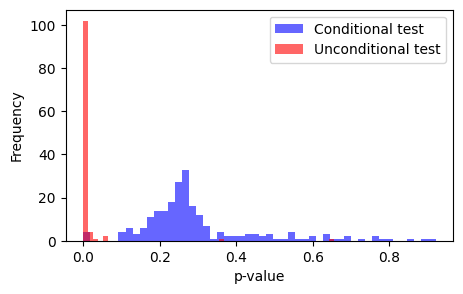

In [200]:
plt.figure(figsize=(5,3))
plt.hist(p_values1, bins=50, color='blue', alpha=0.6, label='Conditional test')
plt.hist(p_values2, bins=50, color='red', alpha=0.6, label='Unconditional test')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

EPSGR ⊥ Emissions | LOGSIZE_t0, SALES

EPSGR ⊥ Emissions | ROE

In [183]:
X = regression_data_shifted  

x = regression_data_shifted.columns.get_loc('total_emission_scope1')
y = regression_data_shifted.columns.get_loc('EPSGR')

z = [regression_data_shifted.columns.get_loc('SALES'), regression_data_shifted.columns.get_loc('LOGSIZE_t-1')]

In [231]:
# run RCIT cross-sectionally
p_values1 = cross_sectional_rcit(X, x, y, z, num_subsets=222)
p_mean = np.average(p_values1)
print(f"average p value: {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values1, 200)
print(f"Chi-square Statistic: {chi2_statistic}, P-value: {p_value}")

average p value: 0.46113726836263785
Chi-square Statistic: 211.85585585585585, P-value: 0.2376160889332276


In [226]:
# run RCIT cross-sectionally
p_values2 = cross_sectional_rcit(X, x, y, z=None, num_subsets=100)
p_mean = np.average(p_values2)
print(f"average p value: {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values2, 100)
print(f"Chi-square Statistic: {chi2_statistic}, P-value: {p_value}")

average p value: 0.009714714143564604
Chi-square Statistic: 7584.379999999996, P-value: 0.0


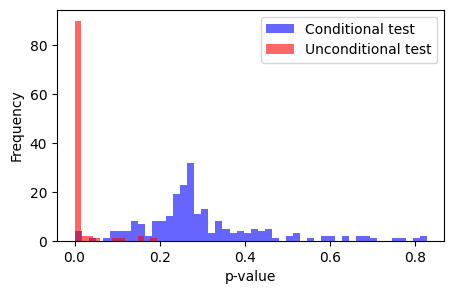

In [229]:
plt.figure(figsize=(5,3))
plt.hist(p_values1, bins=50, color='blue', alpha=0.6, label='Conditional test')
plt.hist(p_values2, bins=13, color='red', alpha=0.6, label='Unconditional test')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [187]:
X = regression_data_shifted  

x = regression_data_shifted.columns.get_loc('total_emission_scope1')
y = regression_data_shifted.columns.get_loc('EPSGR')

z = [regression_data_shifted.columns.get_loc('ROE')]

In [262]:
# run RCIT cross-sectionally
p_values1 = cross_sectional_rcit(X, x, y, z, num_subsets=200)
p_mean = np.average(p_values1)
print(f"average p value: {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values1, 100)
print(f"Chi-square Statistic: {chi2_statistic}, P-value: {p_value}")

average p value: 0.45641471529489247
Chi-square Statistic: 105.91, P-value: 0.2749843437157536


In [257]:
# run RCIT cross-sectionally
p_values2 = cross_sectional_rcit(X, x, y, z=None, num_subsets=111)
p_mean = np.average(p_values2)
print(f"average p value: {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values2, 100)
print(f"Chi-square Statistic: {chi2_statistic}, P-value: {p_value}")

average p value: 0.4440839198612116
Chi-square Statistic: 17.26, P-value: 0.02751275770639172


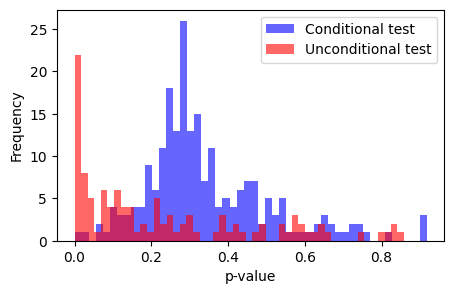

In [251]:
plt.figure(figsize=(5,3))
plt.hist(p_values1, bins=50, color='blue', alpha=0.6, label='Conditional test')
plt.hist(p_values2, bins=50, color='red', alpha=0.6, label='Unconditional test')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.legend()
plt.show()